### **黑K策略**

In [25]:
import pandas as pd
import numpy as np
import zhplot
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore')
# Statsmodel
import statsmodels.api as sm
# from statsmodels.api import add_constant,OLS
# import statsmodels.formula.api as smf
from plyer import notification

#### **Function**

In [26]:
def send_notification():
    notification.notify(
        title='NQ_TXF',
        message='Data Processing Completed',
        timeout=30)
def event_study(df:pd.DataFrame,Xname:str,Yname:str,market_dates:list,event_date:str,backward:int,forward:int):
    '''
    df(DataFrame): which contain market return (X) & stock return (Y)
    Xname(str): name of the columns which contain market return (X)
    Yname(str): name of the columns which contain stock return (Y)
    market_dates(list): dates that the market open
    event_date(str): event date
    backwart(int): days to look backward
    forwart(int) : days to look forward
    return abR : abnormal Return
    '''
    abR = np.nan*(backward+forward+1)
    event = market_dates.index(pd.to_datetime(event_date))
    if event-forward>=0 and event+forward<len(market_dates):
        start = market_dates[event-backward]
        end = market_dates[event+forward]
        window = df.loc[start:end].sort_index(ascending=True).dropna()
        if len(window)==(backward+forward+1):
            X = window[Xname]
            Y = window[Yname]
            X = sm.add_constant(X)
            model = sm.OLS(Y,X).fit()
            expect = model.predict(X)
            abR= Y-expect
            return abR.to_list()
    else:
        pass
def count_mdd(df_profit,window):
    Roll_Max = df_profit.rolling(window, min_periods=1).max()
    # Daily_Drawdown = df_profit/Roll_Max - 1
    Daily_Drawdown = df_profit-Roll_Max
    return Daily_Drawdown

def draw_kbar(df,stock_pid,pct,start_date='2024-03-01',end_date='2025-03-01',f='W',plot_market=False,df_market=None):
    df_kbar = df[(df['股票代號']==stock_pid)&(df.index>=datetime(int(start_date[0:4]),int(start_date[5:7]),int(start_date[8:10])))&(df.index<=datetime(int(end_date[0:4]),int(end_date[5:7]),int(end_date[8:10])))]
    
    if plot_market==True:
        df_market[(df_market.index>=pd.to_datetime(start_date))&(df_market.index<=pd.to_datetime(end_date))][['指數收盤價']]
        df_kbar = pd.concat([df_kbar,df_market],axis=1,join='inner')
    stock_names = df_kbar.iloc[0]['股票名稱']
    df_kbar['color'] = np.where(df_kbar['收盤價']-df_kbar['開盤價']>0,'red',np.where(df_kbar['收盤價']-df_kbar['開盤價']<0,'green','black'))
    df_kbar['height'] = np.where(df_kbar['收盤價']-df_kbar['開盤價']>0,df_kbar['收盤價']-df_kbar['開盤價'],np.where(df_kbar['收盤價']-df_kbar['開盤價']<0,df_kbar['開盤價']-df_kbar['收盤價'],0))
    df_kbar['bottom'] = np.where(df_kbar['收盤價']-df_kbar['開盤價']>0,df_kbar['開盤價'],df_kbar['收盤價'])
    # df_kbar['point'] = np.where(df_kbar['Pct']<pct,df_kbar['最高價']+2,np.nan)
    df_kbar['point'] = np.where((df_kbar['週轉率(%)']>pct)&(df_kbar['開盤價']<df_kbar['收盤價']),df_kbar['最高價']+2,np.nan)
    plt.figure(figsize=(20,5))
    plt.grid(True,linestyle='--')
    plt.title(str(stock_pid)+f' {stock_names} ( Pct : {pct} % )'+'\n'+f'period : {start_date}-{end_date}')
    plt.bar(df_kbar.index,height = df_kbar['height'],bottom=df_kbar['bottom'],color=df_kbar['color'],width=0.8,)
    plt.scatter(df_kbar.index,df_kbar['point'],marker='*',s=200,color='blue')
    plt.xticks(pd.date_range(start=start_date, end=end_date, freq=f))
    plt.xticks(rotation=90,ha='center')
    plt.vlines(df_kbar.index,df_kbar['最高價'],df_kbar['最低價'],'black',alpha=0.5)
    if plot_market==True:
        plt.twinx()
        plt.plot(df_kbar['指數收盤價'])

In [27]:
data = pd.read_csv(r'C:\Users\A51857\Desktop\study\Research\Data\stock_daily_data.csv',index_col=0)
data.index = pd.to_datetime(data.index)
data = data.sort_index(ascending=True)
data['K'] = data['收盤價'] - data['開盤價']
data['color'] = np.where(data['K']>0,'Red',np.where(data['K']<0,'Black','0'))
data = data[pd.to_numeric(data['成交量變動(%)'],errors='coerce').notnull()]
data['成交量變動(%)'] = data['成交量變動(%)'].astype(float)
data['Pct'] = ((data['收盤價'] - data['開盤價'])/data['開盤價'])*100
data['Max Pct'] = ((data['最高價'] - data['開盤價'])/data['開盤價'])*100
data['Min Pct'] = ((data['最低價'] - data['開盤價'])/data['開盤價'])*100
data['跳價'] = np.where((data['開盤價']>=0.01)&(data['開盤價']<10),0.01,
                      np.where((data['開盤價']>=10)&(data['開盤價']< 50),0.05,
                               np.where((data['開盤價']>=50)&(data['開盤價']<100),0.1,
                                        np.where((data['開盤價']>=100)&(data['開盤價']<500),0.5,
                                                 np.where((data['開盤價']>=500)&(data['開盤價']<1000),1,5)))))
data = data.loc['2024-12-01':]
data

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,成交值比重(%),漲跌停,均價,成交量(股),K,color,Pct,Max Pct,Min Pct,跳價
日期,,,,,,,,,,,,,,,,,,,,,
2024-12-02,2379,瑞昱,479.50,497.50,479.50,492.00,16.00,3.36,3.78,1564,...,0.24,0,490.92,1564914,12.5,Red,2.606882,3.753910,0.000000,0.50
2024-12-02,2382,廣達,295.00,296.00,292.50,293.00,2.00,0.69,1.20,11646,...,1.072,0,293.98,11646143,-2.0,Black,-0.677966,0.338983,-0.847458,0.50
2024-12-02,2383,台光電,474.50,504.00,473.00,504.00,35.50,7.58,6.62,13949,...,2.159,0,494.60,13949490,29.5,Red,6.217071,6.217071,-0.316122,0.50
2024-12-02,2404,漢唐,425.00,446.00,425.00,441.00,12.50,2.92,4.90,3438,...,0.47,0,436.95,3438032,16.0,Red,3.764706,4.941176,0.000000,0.50
2024-12-02,2388,威盛,104.00,104.50,102.50,102.50,-0.50,-0.49,1.94,3858,...,0.125,0,103.23,3858847,-1.5,Black,-1.442308,0.480769,-1.442308,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-25,4583,台灣精銳,604.00,616.00,597.00,609.00,28.00,4.82,3.27,1027,...,0.213,0,607.94,1027553,5.0,Red,0.827815,1.986755,-1.158940,1.00
2025-04-25,4581,光隆精密-KY,51.00,51.10,50.90,50.90,0.95,1.90,0.40,11,...,0,0,51.02,11052,-0.1,Black,-0.196078,0.196078,-0.196078,0.10
2025-04-25,4576,大銀微系統,106.50,110.00,105.50,106.50,2.50,2.40,4.33,2705,...,0.099,0,107.42,2705664,0.0,0,0.000000,3.286385,-0.938967,0.50


In [28]:
data_TW = pd.read_csv(r'C:\Users\A51857\Desktop\study\Research\Data\TWindex.csv',index_col=0)
data_TW.index = pd.to_datetime(data_TW.index)
data_TW.columns =  ['指數開盤價','指數最高價','指數最低價','指數收盤價']
data_TW = data_TW.sort_index(ascending=True)
data_TW['指數報酬率'] = data_TW['指數收盤價'].pct_change()*100
data_TW

,指數開盤價,指數最高價,指數最低價,指數收盤價,指數報酬率
日期,,,,,
2000-01-04,8644.91,8803.61,8642.50,8756.55,NaN
2000-01-05,8690.60,8867.68,8668.02,8849.87,1.065717
2000-01-06,8876.59,9023.99,8863.91,8922.03,0.815379
2000-01-07,8856.87,8940.77,8739.43,8845.47,-0.858101
2000-01-10,8918.60,9126.02,8891.79,9102.60,2.906912
...,...,...,...,...,...
2025-04-21,19321.14,19359.96,19080.60,19106.20,-1.489196
2025-04-22,18990.86,19059.65,18793.43,18793.43,-1.637008
2025-04-23,19163.61,19639.14,19163.61,19639.14,4.500030


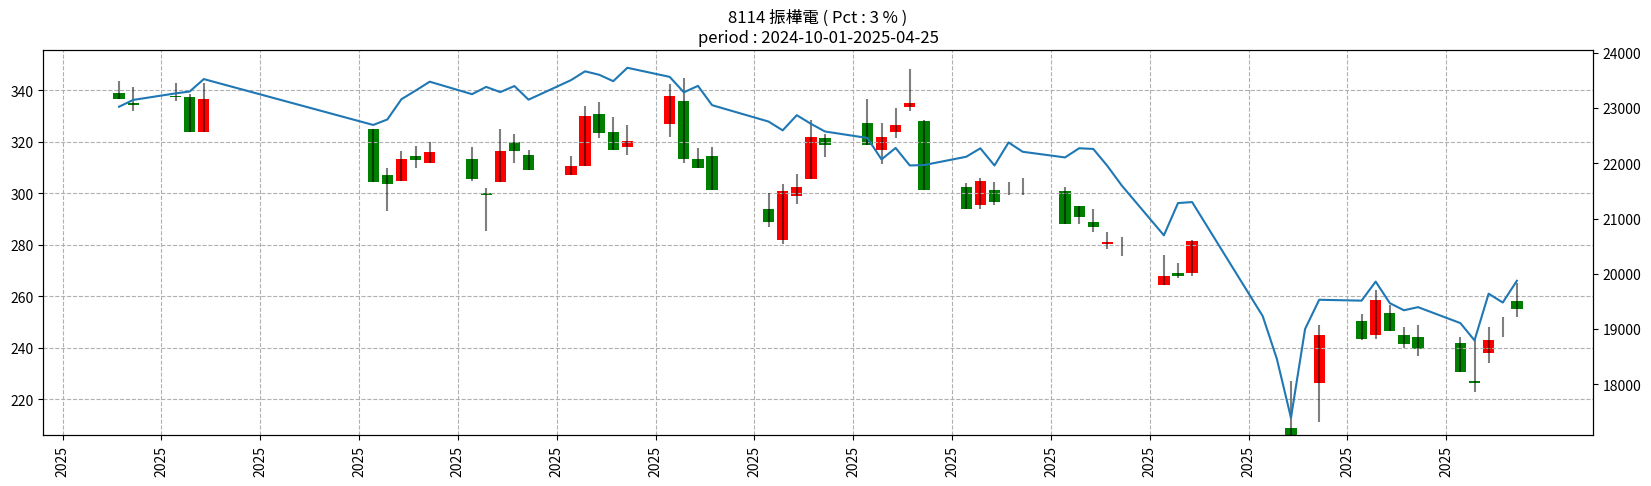

In [29]:
draw_kbar(data,8114,3,'2024-10-01','2025-04-25',f='W',plot_market=True,df_market=data_TW)

### **在一個月內有漲福超過10%的股票**

In [30]:
stock_pool = data.groupby('股票代號').first().index.to_list()
market_dates = data.groupby(data.index).first().index.to_list()
print(stock_pool)
print(market_dates)

[1101, 1102, 1103, 1104, 1108, 1109, 1110, 1201, 1203, 1210, 1213, 1215, 1216, 1217, 1218, 1219, 1220, 1225, 1227, 1229, 1231, 1232, 1233, 1234, 1235, 1236, 1256, 1301, 1303, 1304, 1305, 1307, 1308, 1309, 1310, 1312, 1313, 1314, 1315, 1316, 1319, 1321, 1323, 1324, 1325, 1326, 1337, 1338, 1339, 1340, 1341, 1342, 1402, 1409, 1410, 1413, 1414, 1416, 1417, 1418, 1419, 1423, 1432, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1449, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1459, 1460, 1463, 1464, 1465, 1466, 1467, 1468, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1503, 1504, 1506, 1512, 1513, 1514, 1515, 1516, 1517, 1519, 1521, 1522, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1558, 1560, 1563, 1568, 1582, 1583, 1587, 1589, 1590, 1597, 1598, 1603, 1604, 1605, 1608, 1609, 1611, 1612, 1614, 1615, 1616, 1617, 1618, 1626, 1702, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1717, 1718, 1720, 172

In [31]:
data_ind_index  = pd.read_csv('Data/Industry_index.csv',index_col=0)
data_ind_index = data_ind_index.replace('- -',np.nan)
inds = data_ind_index.groupby('股票代號').first().index.to_list()
print(inds)
df_ind_index = pd.DataFrame()
for i in tqdm(inds):
    df_ind_index[i]=data_ind_index[data_ind_index['股票代號']==i]['收盤價'].astype(float).sort_index(ascending=True).pct_change()*100
df_ind_index.index = pd.to_datetime(df_ind_index.index)
df_ind_index

['TWB11', 'TWB12', 'TWB13', 'TWB14', 'TWB15', 'TWB16', 'TWB17', 'TWB18', 'TWB19', 'TWB20', 'TWB21', 'TWB22', 'TWB23', 'TWB25', 'TWB26', 'TWB27', 'TWB28', 'TWB29', 'TWB30', 'TWB31', 'TWB32', 'TWB33', 'TWB34', 'TWB35', 'TWB36', 'TWB37', 'TWB38', 'TWB39', 'TWB40', 'TWB41', 'TWB42', 'TWB43', 'TWB44', 'TWB99']


100%|██████████| 34/34 [00:00<00:00, 219.82it/s]


,TWB11,TWB12,TWB13,TWB14,TWB15,TWB16,TWB17,TWB18,TWB19,TWB20,...,TWB36,TWB37,TWB38,TWB39,TWB40,TWB41,TWB42,TWB43,TWB44,TWB99
日期,,,,,,,,,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.374979,0.437590,1.215351,0.085618,-1.125207,-0.746570,-0.380000,0.062933,-0.419937,0.009767,...,0.180647,0.453347,-0.025178,-0.616867,0.704305,NaN,NaN,NaN,NaN,-0.200690
2020-01-06,-1.060736,-1.067038,-0.045455,-0.751306,-0.256611,-1.138443,-0.421602,-0.566038,0.145590,-0.996094,...,-1.003528,-1.838024,-0.679987,-1.096846,-0.891145,NaN,NaN,NaN,NaN,-0.645617
2020-01-07,0.276673,-0.165284,-0.776868,-0.050591,-0.878076,-0.349578,-0.645161,-0.759013,-0.741929,-0.345236,...,-0.863230,-2.666555,-0.591666,-0.008597,-1.081266,NaN,NaN,NaN,NaN,0.092323
2020-01-08,-0.247169,-0.915897,-1.267998,-0.909227,-1.246967,-0.846059,-0.801542,-0.382409,-1.303030,-0.890825,...,-0.439367,-1.245277,-0.773744,-1.014530,-1.967553,NaN,NaN,NaN,NaN,-0.847879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,-0.521415,0.295321,-1.023560,-0.582521,0.409363,-1.835249,0.058030,-2.235318,-0.539549,-2.386163,...,0.077110,0.185218,-0.677350,0.923274,1.017745,-0.211689,0.782748,-0.390873,1.778030,-0.584759
2025-03-26,0.992138,0.044979,0.312026,0.554574,1.894731,3.137423,-0.028998,1.351070,0.195008,0.484559,...,0.017781,1.113654,0.977212,0.436237,0.652286,0.239808,0.015850,0.063633,0.015954,0.354787
2025-03-27,0.691999,0.365234,0.168859,-0.955304,-1.041319,-0.666736,-1.145758,0.225595,-0.743126,0.460630,...,-0.142222,-1.362588,-0.625952,-1.509657,-2.720565,-0.266838,-0.110935,-0.519343,-0.630085,-0.567512


In [32]:
# market_ars = [0]*n
# for i in tqdm(range(n,len(data))):
#     row = data.iloc[i]
#     date = row.name
#     lastn_day = market_dates.index(date)-n
#     stock = row['股票代號']
#     market_index = data_industry[data_industry['股票代號']==stock]['產業指數代號']
#     try:
#         market_ar = row['Pct'] - df_ind_index[(df_ind_index.index<=date)&(df_ind_index.index>=lastn_day)][market_index].values[0]
#     except:
#         market_ar=0
#     market_ars.append(market_ar)
# data['Market AR'] = market_ars

In [ ]:
for i in tqdm(data_TW.index):
    data.loc[i,'Index Return']= data_TW.loc[i,'指數報酬率']
data['AR'] = data['Pct'] - data['Index Return']

n=20
# data_industry = pd.read_csv('Data/Stock_basic_data.csv')
# data_industry = data_industry.replace('- -',np.nan)
data = data.dropna()
for i in tqdm(range(n,len(market_dates))):
    date = market_dates[i]
    lastn_day = market_dates[market_dates.index(date)-n]
    for stock in data.loc[date]['股票代號']:
        # market_index = data_industry[data_industry['股票代號']==stock]['產業指數代號']
        Y = data[(data['股票代號']==stock)].loc[lastn_day:date]['Pct']
        # X = df_ind_index[(df_ind_index.index<=date)&(df_ind_index.index>=lastn_day)][market_index]
        X = data[(data['股票代號']==stock)].loc[lastn_day:date]['Index Return']
        X = sm.add_constant(X)
        model = sm.OLS(Y,X).fit()
        expect = model.predict(X)
        abR= Y-expect
        abR_latest=abR[-1]

        # data.loc[(data.index==date)&(data['股票代號']==stock),'Predict AR'] = abR_latest
        data.loc[(data.index==date)&(data['股票代號']==stock),'Predict AR'] = expect

# data_industry = pd.read_csv('Data/Stock_basic_data.csv')
# data_industry = data_industry.replace('- -',np.nan)
data = data.dropna()


# car3_list = [0,0,0,]
# for i in tqdm(range(3,len(data))):
#     row = data.iloc[i]
#     stock = row['股票代號']
#     today = row.name
#     yesterday = market_dates[market_dates.index(today)-1]
#     lastnday = market_dates[market_dates.index(today)-1-n]
#     car = data[(data['股票代號']==stock)&(data.index>=pd.to_datetime(lastnday))&(data.index<=pd.to_datetime(yesterday))]['AR'].sum()
#     car3_list.append(car)
# data['CAR3'] = car3_list

100%|██████████| 74/74 [02:56<00:00,  2.39s/it]


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xaa in position 0: invalid start byte

In [34]:
# data['Month_pct'] = (data.groupby('股票代號')['收盤價'].pct_change(10)*100)
data['last_O'] = (data.groupby('股票代號')['開盤價'].shift(1))
data['last_C'] = (data.groupby('股票代號')['收盤價'].shift(1))
data['last_C3'] = (data.groupby('股票代號')['收盤價'].shift(3))
data['last_H'] = (data.groupby('股票代號')['最高價'].shift(1))
data['last_T'] = (data.groupby('股票代號')['週轉率(%)'].shift(1))
data['Daily_T'] = (data.groupby('日期')['週轉率(%)'].quantile(0.1))
data['Daily_TT'] = (data.groupby('日期')['週轉率(%)'].quantile(0.99))
data['last_V'] = data.groupby('日期')['成交量'].shift(1)
# data['Pct_last'] = data.groupby('股票代號')['Pct'].shift(1)
# data['AR'] = data['漲幅(%)'] - data['Index Return']
# data['3AR'] = data.groupby('股票代號').rolling(3)['AR'].sum()>5
# df_drop = data[(data['last_T']>data['Daily_T']*3)&(data['開盤價']>data['last_C'])&(data['最高價']/data['開盤價']-1>=0.02)]
# df_drop = data[(data['AR']<=0)&(data['CAR3']>=12)&(data['開盤價']>=100)&(data['開盤價']<1000)]
df_drop = data[(data['AR']<=-5)&(data['AR']>-7)&(data['AR']<data['Predict AR'])&(data['開盤價']>=100)&(data['開盤價']<=1000)&(data['週轉率(%)']>data['Daily_T'])&(data['週轉率(%)']<data['Daily_TT'])]
# df_drop = data[(data['AR']<=-5)&(data['AR']<data['Predict AR'])&(data['開盤價']>=100)&(data['開盤價']<1000)]
df_drop

,股票代號,股票名稱,開盤價,最高價,最低價,收盤價,漲跌,漲幅(%),振幅(%),成交量,...,AR,Predict AR,last_O,last_C,last_C3,last_H,last_T,Daily_T,Daily_TT,last_V
日期,,,,,,,,,,,,,,,,,,,,,
2025-01-02,6415.0,矽力*-KY,407.0,407.0,377.0,379.0,-24.5,-6.07,7.43,4316.0,...,-5.998169,-1.324176,398.5,403.5,413.5,406.0,0.25,0.08,5.0940,956.0
2025-01-06,2368.0,金像電,242.0,242.0,231.5,236.0,-1.0,-0.42,4.43,9229.0,...,-5.270511,-1.447256,240.0,237.0,241.5,240.5,1.18,0.08,3.3658,13844.0
2025-01-06,2360.0,致茂,374.5,375.0,349.0,363.5,10.0,2.83,7.36,10015.0,...,-5.728421,-2.800589,387.5,353.5,409.0,388.0,2.42,0.08,3.3658,837.0
2025-01-06,1319.0,東陽,111.5,112.0,109.0,109.0,-1.5,-1.36,2.71,1862.0,...,-5.033324,-0.754189,112.0,110.5,112.0,113.0,0.31,0.08,3.3658,17659.0
2025-01-06,6285.0,啟碁,136.0,136.5,132.5,132.5,-2.0,-1.49,2.97,3113.0,...,-5.364701,-3.466690,136.5,134.5,137.5,138.0,0.62,0.08,3.3658,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-25,6239.0,力成,116.0,116.0,111.0,111.5,-2.5,-2.19,4.39,6867.0,...,-5.901610,0.307795,117.5,114.0,109.5,117.5,1.03,0.03,11.9756,349.0
2025-04-25,6176.0,瑞儀,157.5,157.5,149.0,150.5,-9.0,-5.64,5.33,7997.0,...,-6.466745,0.325195,160.0,159.5,154.5,161.5,0.33,0.03,11.9756,799.0
2025-04-25,6438.0,迅得,161.5,161.5,152.5,154.0,1.0,0.65,5.88,4518.0,...,-6.666263,-0.130242,149.0,153.0,134.0,156.5,7.66,0.03,11.9756,2940.0


### **跌幅超過某比例事件分析**
- 上市公司

In [42]:
data_black = df_drop.copy()
df_daily_group = df_drop.groupby(df_drop.index)['股票代號'].apply(list).to_frame()
df_daily_group = pd.concat([df_daily_group,data_TW['指數報酬率']],axis=1).dropna()
df_daily_group.columns = ['Group','TW_index']
df_daily_group
# df_daily_group.to_csv('df_daily_stock.csv')

,Group,TW_index
日期,,
2025-01-02,[6415.0],-0.881437
2025-01-06,"[2368.0, 2360.0, 1319.0, 6285.0]",2.791172
2025-01-09,"[2603.0, 6806.0, 3017.0]",-1.393581
2025-01-13,[2360.0],-2.275044
2025-01-16,[6285.0],2.267554
2025-01-17,"[6451.0, 8467.0, 8028.0, 6957.0, 6890.0, 5284.0]",0.534113
2025-02-04,"[6691.0, 8028.0, 6139.0, 3036.0, 4771.0]",0.437327
2025-02-10,"[6183.0, 6438.0]",-0.963146
2025-02-11,"[2723.0, 4994.0]",0.567303


In [36]:
df_industry = pd.DataFrame(columns=data_industry.groupby('產業名稱').first().index)
for stock in df_drop['股票代號']:
    industry = data_industry[data_industry['股票代號']==stock]['產業名稱']
    df_industry.loc[len(df_industry[industry]),industry] = stock
df_industry.loc['Count'] = df_industry.count(axis=0)
df_industry = df_industry.dropna(axis=0)
df_industry = df_industry.T

df_industry.sort_values('Count',inplace=True,ascending=False)
plt.bar(df_industry.index,df_industry['Count'],)
plt.title('觸發條件者所在產業')
plt.xticks(rotation=90)
plt.tight_layout()

NameError: name 'data_industry' is not defined

In [37]:
barckward_days = 10
forward_days = 20
df_AR = pd.DataFrame(index=list(range(-barckward_days,forward_days+1)))
marketdates = data.sort_index(ascending=True).groupby(data.index).first().index.to_list()
for d in tqdm(df_daily_group.index):
    group = df_daily_group.loc[d]['Group']
    for stock in group:
        df_stock = data[data['股票代號']==stock][['收盤價','開盤價']].sort_index(ascending=True)
        df_stock['Market Close'] = data_TW['指數收盤價']
        df_stock['Market Open'] = data_TW['指數開盤價']
        # print(df_stock)
        df_stock.columns = ['Stock Close','Stock Open','Market Close','Market Open']
        # df_stock['Stock Return'] = (df_stock['Stock Close'] - df_stock['Stock Open'].shift(1))/df_stock['Stock Open'].shift(1)
        # df_stock['Market Return'] = (df_stock['Market Close'] - df_stock['Market Open'].shift(1))/df_stock['Market Open'].shift(1)
        df_stock['Stock Return'] =  df_stock['Stock Close'].pct_change()
        df_stock['Market Return'] = df_stock['Market Close'].pct_change()
        df_AR[str(stock)+':'+str(d)[:10]] = event_study(df_stock,'Market Return','Stock Return',marketdates,str(d),barckward_days,forward_days)
df_AR = df_AR.dropna(axis=1)
df_AR['AAR'] = df_AR.mean(axis=1)
df_AR['CAR'] = df_AR['AAR'].cumsum()
df_AR


100%|██████████| 43/43 [00:00<00:00, 74.13it/s]


,6415.0:2025-01-02,2368.0:2025-01-06,2360.0:2025-01-06,1319.0:2025-01-06,6285.0:2025-01-06,2603.0:2025-01-09,6806.0:2025-01-09,3017.0:2025-01-09,2360.0:2025-01-13,6285.0:2025-01-16,...,2421.0:2025-03-19,6805.0:2025-03-19,6215.0:2025-03-20,2455.0:2025-03-24,2486.0:2025-03-24,6805.0:2025-03-24,6442.0:2025-03-24,3029.0:2025-03-25,AAR,CAR
-10,-0.005100,0.022019,0.034062,0.030421,0.080486,-0.003091,-0.006512,-0.001282,0.006510,-0.014371,...,0.000135,-0.004282,-0.001267,0.019271,0.032180,-0.006733,-0.008263,-0.018171,0.003168,3.167649e-03
-9,0.009930,-0.025285,-0.032311,0.000910,-0.019922,-0.000545,-0.000821,0.011588,0.014127,-0.008036,...,0.000938,0.052440,-0.020355,-0.028485,0.030029,0.051509,-0.025893,0.065722,0.007474,1.064143e-02
-8,0.016488,-0.022861,-0.000030,-0.001400,-0.016126,-0.020096,-0.005167,-0.007362,0.030725,-0.035665,...,0.056756,0.008176,-0.013284,0.021082,-0.010592,0.065625,0.055261,-0.000445,0.007352,1.799388e-02
-7,-0.001708,0.032405,0.012768,-0.006663,0.012937,0.003291,-0.003016,-0.001949,-0.019405,-0.008815,...,0.058963,-0.009134,-0.074779,-0.014963,0.021318,0.018491,0.054721,0.004558,0.007825,2.581881e-02
-6,0.006816,0.008989,-0.016639,-0.001519,0.024028,0.005716,-0.006050,0.012099,-0.100395,-0.002760,...,0.029493,0.048481,0.008539,0.028758,0.006264,0.042918,-0.000204,-0.045134,0.000343,2.616189e-02
-5,0.010126,0.038550,0.006532,-0.036474,-0.030004,0.018535,-0.000800,0.010064,-0.017161,-0.027109,...,0.012802,0.063977,0.098363,0.004611,0.043256,-0.028630,-0.012152,-0.005464,0.007591,3.375331e-02
-4,0.002474,-0.010606,0.013092,0.026843,-0.022615,0.019679,0.007024,0.012241,0.063079,0.023632,...,-0.025146,0.015622,-0.006583,0.027460,-0.002703,-0.007871,-0.002005,0.029427,0.008010,4.176334e-02
-3,-0.011963,0.013242,0.029040,-0.012765,0.014544,-0.028580,-0.003914,-0.048735,0.022358,-0.037045,...,0.025279,0.040799,-0.024707,-0.014435,-0.022710,-0.028160,0.024974,-0.051649,0.003046,4.480927e-02
-2,-0.013670,-0.003061,-0.021547,0.000985,-0.021832,-0.005355,0.002075,0.011352,0.036655,0.057799,...,-0.025890,-0.030409,-0.000301,-0.002707,0.013264,0.012506,-0.024599,0.016166,0.002319,4.712784e-02
-1,0.009882,-0.006190,-0.099920,-0.015461,-0.009205,0.013042,-0.017303,-0.008511,0.038671,0.002419,...,0.001997,-0.009647,0.025985,0.075574,-0.009964,0.029751,0.015229,-0.032270,0.001209,4.833690e-02


Day Trading acc : 59.70149253731343 %


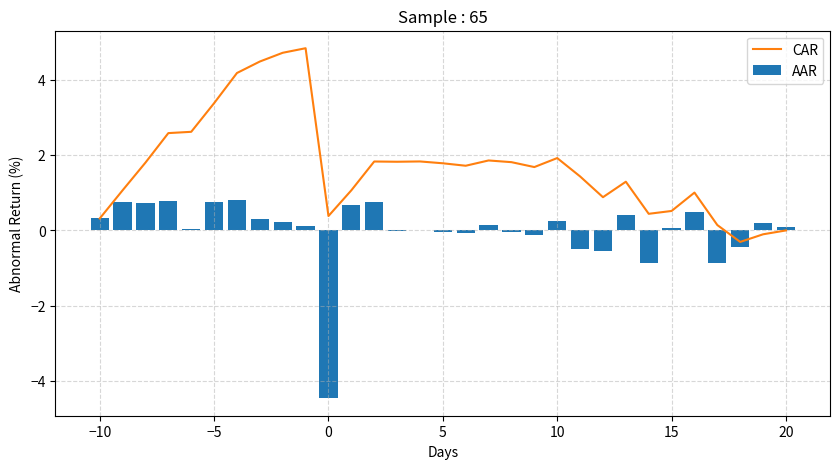

In [38]:
next_day = pd.Series(df_AR.loc[1])
acc = (len(next_day[next_day>0])/len(next_day))*100
print(f'Day Trading acc : {acc} %')
plt.figure(figsize=(10,5))
plt.title(f'Sample : {len(df_AR.columns[:-2])}')
plt.xlabel('Days')
plt.ylabel('Abnormal Return (%)')
plt.grid(True,alpha=0.5,linestyle = '--')
plt.bar(df_AR.index,df_AR['AAR']*100,label='AAR')
plt.plot(df_AR['CAR']*100,label='CAR',color='C01')
plt.legend()

### **plot**

In [39]:
#持有時間
n = 20
stoploss=100
stopprofit=100
amount = 5000000
df_profit = pd.DataFrame()
marketdates = data.sort_index(ascending=True).groupby(data.index).first().index.to_list()
df_daily_group = data_black.groupby(data_black.index)['股票代號'].apply(list).to_frame()
dates = df_daily_group.index
total_trade =0
win_trade = 0
for d in tqdm(dates[:]):
    today = marketdates.index(d)
    if today+n<len(marketdates):
        tommorw = marketdates[today+1]
        next_ndays = marketdates[today+n]
        group = df_daily_group.loc[d,'股票代號']
        amount_per = amount/len(group)
        total = 0
        win  = 0
        for i in group:
                try:
                    buy_price = data[(data.index==tommorw)&(data['股票代號']==i)]['開盤價'].values[0]*(1+0.004425)
                    num = amount_per/buy_price
                    sell_price = data[(data.index==next_ndays)&(data['股票代號']==i)]['開盤價'].values[0]*(1-0.001425)
                    # sell_price = data[(data.index==tommorw)&(data['股票代號']==i)]['最高價'].values[0] * (1-0.004425)
                    # buy_price = data[(data.index==next_ndays)&(data['股票代號']==i)]['收盤價'].values[0]*(1+0.001425)
                    sell_price_low = data[(data.index>=tommorw)&(data.index<next_ndays)&(data['股票代號']==i)]['最低價'].to_list()
                    sell_price_high = data[(data.index>=tommorw)&(data.index<next_ndays)&(data['股票代號']==i)]['最高價'].to_list()
                    # index_pcts = data_TW[(data_TW.index>=tommorw)&(data_TW.index<next_ndays)]['指數開盤價']
                    index_pcts = data_TW[(data_TW.index>=tommorw)&(data_TW.index<next_ndays)]['指數報酬率']
                    for j in range(len(sell_price_low)):
                        low = sell_price_low[j]
                        high = sell_price_high[j]
                        # index_pct = (index_pcts[sell_prices.index(sp)]/data_TW.loc[tommorw]['指數開盤價'] -1)
                        index_pct = index_pcts[j-1]
                        if low<=buy_price*(min(1-stoploss+index_pct,0.75)):
                            sell_price = buy_price*(min(1-stoploss+index_pct,0.75))
                            break
                        if high>=buy_price*(max(1+stopprofit,1+stopprofit+index_pct)):
                            sell_price = buy_price*(max(1+stopprofit,1+stopprofit+index_pct))
                            break
                    total+=((sell_price-buy_price)*1000*num)
                    # total+=((sell_price-buy_price))
                    total_trade+=1
                    if (sell_price-buy_price)>0:
                        win+=1
                        win_trade+=1
                except:
                     pass
    df_profit.loc[d,'Profit'] = total
    df_profit.loc[d,'win rate'] = (win/len(group))*100
df_profit['cumsum'] = df_profit['Profit'].cumsum()
df_profit['mdd'] = count_mdd(df_profit['cumsum'],len(df_profit))
# df_profit['ret'] = ((df_profit['Profit'].pct_change()+1).cumprod()-1)
df_profit

100%|██████████| 43/43 [00:00<00:00, 159.99it/s]


,Profit,win rate,cumsum,mdd
2025-01-02,9.815249e+06,100.000000,9.815249e+06,0.000000e+00
2025-01-06,1.185774e+07,50.000000,2.167299e+07,0.000000e+00
2025-01-09,1.913285e+08,66.666667,2.130015e+08,0.000000e+00
2025-01-13,-2.943253e+08,0.000000,-8.132389e+07,-2.943253e+08
2025-01-16,5.734096e+08,100.000000,4.920857e+08,0.000000e+00
2025-01-17,1.648062e+08,33.333333,6.568920e+08,0.000000e+00
2025-02-04,5.542312e+08,80.000000,1.211123e+09,0.000000e+00
2025-02-10,-8.230051e+08,0.000000,3.881181e+08,-8.230051e+08
2025-02-11,-7.093146e+07,50.000000,3.171866e+08,-8.939366e+08
2025-02-12,-5.788923e+08,16.666667,-2.617057e+08,-1.472829e+09


Total Trade : 76
Trade Freq : 45.739999999999995%
Win Rate : 22 %
PL Ratio : 0.0449


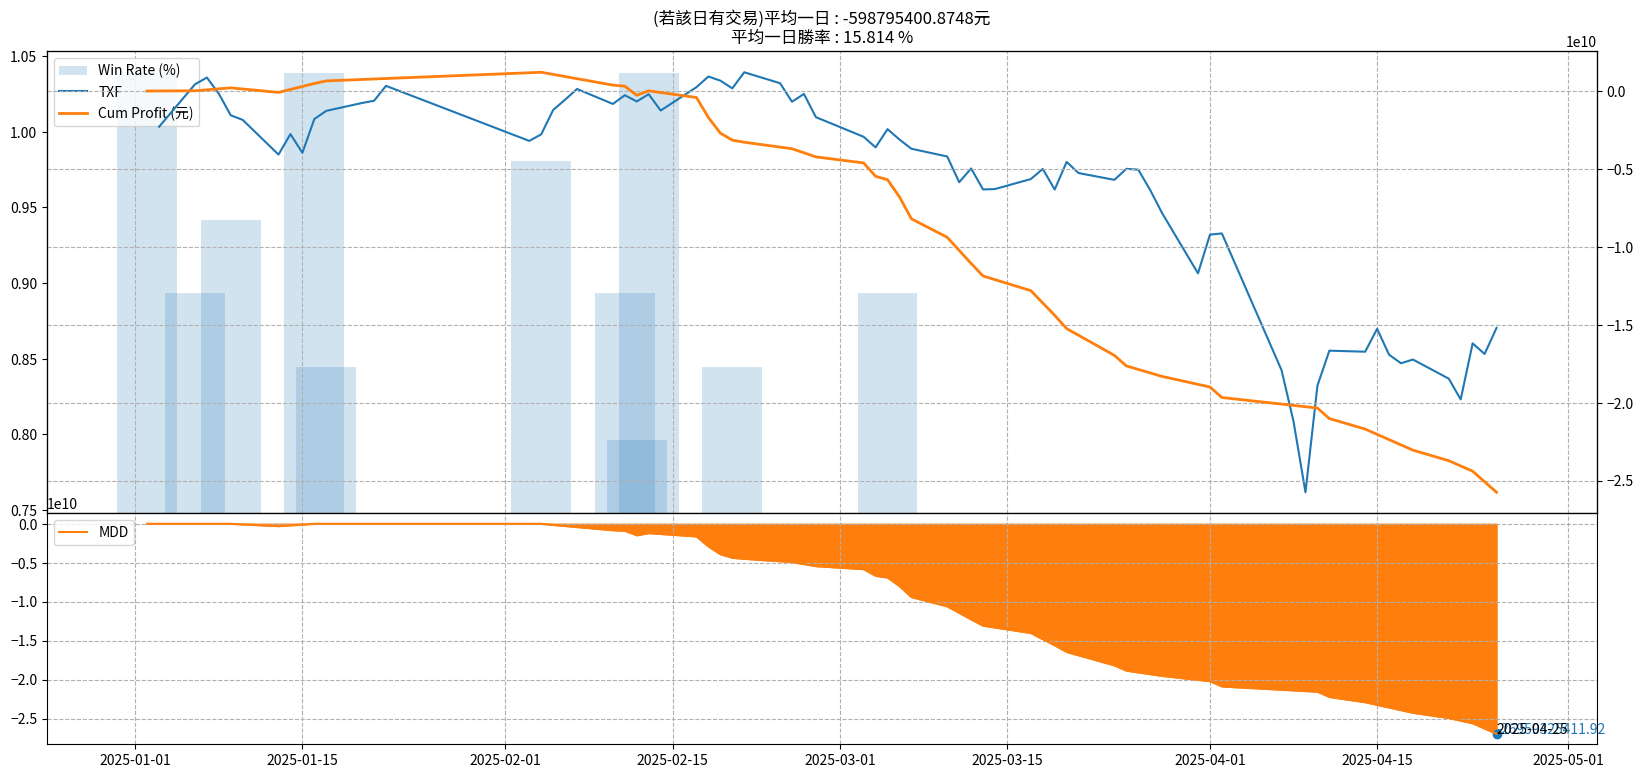

In [40]:
mean_unit_profit, mean_win_rate = df_profit[['Profit','win rate']].mean().values
print(f'Total Trade : {total_trade}')
print(f'Trade Freq : '+ str(round(len(df_daily_group)/len(market_dates),4)*100) + '%')
print(f'Win Rate : {round(win_trade*100/total_trade)} %')
print(f'PL Ratio : '+str(abs(round(df_profit['cumsum'].max()/df_profit['mdd'].min(),4))))
fig,ax1 = plt.subplots(2,figsize=(20,9),sharex=True,gridspec_kw={'height_ratios': [2,1]})
fig.subplots_adjust(hspace = 0)
# ax1[0].set_xticks(pd.date_range(start=datetime.strftime(df_profit.iloc[0].name,'%Y-%m-%d'), end=datetime.strftime(df_profit.iloc[-1].name,'%Y-%m-%d'), freq="M"))
# ax1[0].set_xticklabels(pd.date_range(start=datetime.strftime(df_profit.iloc[0].name,'%Y-%m-%d'), end=datetime.strftime(df_profit.iloc[-1].name,'%Y-%m-%d'), freq="M"),rotation=90)
ax1[0].set_title(f'(若該日有交易)平均一日 : {round(mean_unit_profit,4)}元'+'\n'+f'平均一日勝率 : {round(mean_win_rate,4)} %')
ax2 = ax1[0].twinx()
ax3 = ax2.twinx()
ax1[0].grid(True,linestyle='--')
ax1[0].get_yaxis().set_visible(False)
ax1[0].bar(df_profit.index,df_profit['win rate'],alpha=0.2,width=5,label='Win Rate (%)',linewidth=0.5)
ax2.plot((data_TW[(data_TW.index>=df_profit.iloc[0].name)&(data_TW.index<=df_profit.iloc[-1].name)]['指數收盤價'].pct_change()+1).cumprod(),label='TXF')
ax3.plot(df_profit['cumsum'],color='C01',label='Cum Profit (元)',linewidth=2)
ax1[1].grid(True,linestyle='--')
ax3.grid(True,linestyle='--')

lines, labels = ax1[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax1[0].legend(lines + lines2 + lines3, labels + labels2 + labels3 , loc='upper left')


ax1[1].plot(df_profit.index,df_profit['mdd'],label='MDD',color='C01')
ax1[1].fill_between(df_profit.index,df_profit['mdd'],color='C01')
ax1[1].scatter(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index,df_profit['mdd'].min(),color='C10')
ax1[1].text(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index,df_profit['mdd'].min(),round(df_profit['mdd'].min(),2),color='C10')
ax1[1].text(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index,df_profit['mdd'].min()-150,str(df_profit[df_profit['mdd']==df_profit['mdd'].min()].index.values[0])[:10],color='Black')
ax1[1].legend(loc='upper left')

